In [1]:
import sys
import os
import yaml

sys.path.append(os.getenv("CODE_PATH"))
sys.path.append(os.getenv("FIN_DATABASE_PATH"))


import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import ta
from log_config import setup_logging
from Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from Pre_Processing.pre_processing import PreProcessing
from Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
import math
from IPython.display import display
import scipy.stats as stats
import seaborn as sns


## Performing  Data Analysis in specific stocks

In [2]:
tickers = ['AAPL', 'MSFT', 'DIS', 'BA', 'JPM']

In [3]:
pipe = Pipeline(tickers)

In [4]:
daily_data = pipe.pipeline()
hourly_data = pipe.pipeline(timespan='hour')

In [5]:
def stock_stats(data, columns=None):
    """ 
    Display descriptive statistics for specified columns for each ticker.
    
    Params:
    data (dict or DataFrame): A dictionary where the keys are the ticker symbols and values are DataFrames
                              or a single DataFrame with MultiIndex (tickers as one level).
    columns (list or str): List of columns to include in the stats table. 
                           If None, default is 'close' column.
    """
    
    if columns is None:
        columns = ['close']
        
    all_stats = {}

    if isinstance(data, dict):  # Case 1: Dict of DataFrames
        for ticker, df in data.items():
            stats = display_stats(df, columns, ticker)
            all_stats[ticker] = stats

    elif isinstance(data, pd.DataFrame):  # Case 2: Combined DataFrame with MultiIndex
        grouped = data.groupby(level=0)
        
        for ticker, df in grouped:
            stats = display_stats(df.droplevel(0), columns, ticker)
            all_stats[ticker] = stats

    combined_stats = pd.concat(all_stats, axis=1)
    

    tickers = list(all_stats.keys())
    stats_columns = combined_stats.columns.levels[0]
    
    combined_stats.columns = pd.MultiIndex.from_product([tickers, columns])
    
    combined_stats = combined_stats.sort_index(axis=1, level=0)
    
    return combined_stats.round(4).style.set_table_styles([{
        'selector': 'th',
        'props': [('font-size', '12px'), ('text-align', 'center')]
    }])


def display_stats(df, columns, ticker, decimals=4):
    """
    Helper function to calculate and return stats for a given DataFrame and columns.

    Returns:
    DataFrame: The descriptive statistics including skewness and kurtosis.
    """
    
    stats = df[columns].describe()
    skewness = df[columns].skew()
    kurtosis = df[columns].kurtosis()
    
    # Adding skewness and kurtosis to the df
    stats.loc['skewness'] = skewness
    stats.loc['kurtosis'] = kurtosis
    
    stats = stats.round(decimals)
    
    
    if len(columns) > 1:
        stats.columns = pd.MultiIndex.from_product([[ticker], columns])
    else:
        stats.columns = [ticker] 
    
    return stats


In [6]:
stock_stats = stock_stats(daily_data, columns = ['close', 'open', 'low',])
stock_stats

In [7]:
class DataViz:
    def __init__(self, tickers: dict,):
        self.tickers = tickers


    def plot_ohlc(self, tickers: list = None, start_date: str = None, end_date: str = None):
        if tickers is None:
            tickers = list(self.tickers.keys())
            
        for ticker in tickers:
            df = self.tickers[ticker]
            
            if start_date:
                df = df[df.index >= start_date]
            if end_date:
                df = df[df.index <= end_date]
                
            fig = go.Figure(data=[go.Candlestick(x=df.index,
                                                    open=df['open'],
                                                    high=df['high'],
                                                    low=df['low'],
                                                    close=df['close'])])
            fig.update_layout(title=f'{ticker} OHLC Data', xaxis_title='Date', yaxis_title='Price')
            
            fig.show()

    def plot_data(self, column:str = 'close', plot_type:str = 'line', separate_plots = True):
        """
            Plots the specified column for each ticker.

            Parameters:
            column (str): The column name to plot (e.g., 'Close', 'Returns').
            plot_type (str): The type of plot ('line', 'bar', etc.). Default is 'line'.
            """
        
        num_tickers = len(self.tickers)
        num_rows = math.ceil(num_tickers / 3)
        
        if separate_plots:
            for ticker in self.tickers:
                df = self.tickers[ticker]
                
                if column not in df.columns:
                    print(f'Column {column} not found in {ticker} data. Skipping to the next ticker.')
                    continue
                
                
                fig = go.Figure()
                
                if plot_type == 'line':
                    fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name=ticker))
                elif plot_type == 'bar':
                    fig.add_trace(go.Bar(x=df.index, y=df[column], name=ticker))
                
                
                fig.update_layout(title=f'{ticker} - {column.capitalize()} Data',
                                  xaxis_title='Date',
                                  yaxis_title=column.capitalize(),
                                  showlegend=True)
                
                fig.show()
        else:
            fig = go.Figure()
            
            for ticker in self.tickers:
                df = self.tickers[ticker]
                
                if column not in df.columns:
                    print(f'Column {column} not found in {ticker} data. Skipping to the next ticker.')
                    continue
                
                if plot_type == 'line':
                    fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name=ticker))
                elif plot_type == 'bar':
                    fig.add_trace(go.Bar(x=df.index, y=df[column], name=ticker))
            
            # Update layout with titles and labels
            fig.update_layout(title=f'{column.capitalize()} Data for Selected Tickers',
                              xaxis_title='Date',
                              yaxis_title=column.capitalize(),
                              showlegend=True)
            
            fig.show()
            
            
    def plot_distribution(self, column: str = 'log_ret', plot_type: str = 'qq', separate_plots: bool = True):
        """
        Plots the distribution of the specified column for each ticker.

        Params:
        column (str): The column name to plot (e.g., 'Close', 'Returns').
        plot_type (str): The type of distribution plot ('hist', 'kde', 'qq'). Default is 'hist'.
        separate_plots (bool): If True, creates separate plots for each ticker. If False, plots all tickers on the same plot.
        """
        
        num_tickers = len(self.tickers)
        num_rows = math.ceil(num_tickers / 3)
        
        if separate_plots:    
            fig, ax = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
            ax = ax.flatten()
            
            for i, ticker in enumerate(self.tickers):
                if column not in self.tickers[ticker].columns:
                    print(f'Column {column} not found in {ticker} data. Skipping to the next ticker.')
                    continue
                
                data = self.tickers[ticker][column].dropna()

                if plot_type == 'hist':
                    sns.histplot(data, kde=False, ax=ax[i], label=ticker)
                elif plot_type == 'kde':
                    sns.kdeplot(data, ax=ax[i], label=ticker)
                elif plot_type == 'qq':
                    stats.probplot(data, dist="norm", plot=ax[i])
                
                ax[i].set_title(f'{ticker} - {column.capitalize()} Distribution')
                ax[i].legend()
                
            for j in range(i + 1, len(ax)):
                ax[j].axis('off')
        else:
            fig, ax = plt.subplots(figsize=(12, 8))
            
            for ticker in self.tickers:
                if column not in self.tickers[ticker].columns:
                    print(f'Column {column} not found in {ticker} data. Skipping to the next ticker.')
                    continue

                data = self.tickers[ticker][column].dropna()
                
                if plot_type == 'hist':
                    sns.histplot(data, kde=False, ax=ax, label=ticker)
                elif plot_type == 'kde':
                    sns.kdeplot(data, ax=ax, label=ticker)
                elif plot_type == 'qq':
                    stats.probplot(data, dist="norm", plot=ax)
                    break  # We can only plot one ticker for qq plot

            ax.set_title(f'{column.capitalize()} Distribution for Selected Tickers')
            ax.legend()

        plt.tight_layout()
        plt.show()
        
        
    def correlation_heatmap(self, column: str = 'close'):
        """
        Plot a heatmap of the correlation matrix for the specified column.

        Params:
        column (str): The column name to use for the correlation matrix. Default is 'Close'.
        """
        if isinstance(self.tickers, dict):
            data = pd.concat({ticker: df[column] for ticker, df in self.tickers.items()}, axis=1)
        else:
            data = self.tickers[column].unstack(level=0)
        
        corr = data.corr()
        title = f'Correlation Matrix for {column.capitalize()}'
    
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
        ax.set_title(f'Correlation Matrix for {column.capitalize()}')
        
        plt.show()
        
        
    def rolling_corr(self, column: str = 'close', window: int = 30, pairs: list = None):
        """
        Plot rolling correlation for the specified window and column.

        Params:
        column (str): The column name to use for the correlation matrix. Default is 'close'.
        window (int): The window size for the rolling correlation. Default is 30.
        pairs (list): A list of tuples specifying which pairs of tickers to plot. If None, all pairs are plotted.
                    Example: [('AAPL', 'MSFT'), ('DIS', 'JPM')]
        """


        if isinstance(self.tickers, dict):
            data = pd.concat({ticker: df[column] for ticker, df in self.tickers.items()}, axis=1)
        else:
            data = self.tickers[column].unstack(level=0)
        
        rolling_corr = data.rolling(window=window).corr().dropna()

        # If no specific pairs are provided, plot all pairs
        if pairs is None:
            pairs = [(ticker1, ticker2) for i, ticker1 in enumerate(data.columns) 
                                    for j, ticker2 in enumerate(data.columns) if i < j]
        
        for ticker1, ticker2 in pairs:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            pair_corr = rolling_corr.loc[(slice(None), ticker1), ticker2]

            # Check if the pair_corr is empty and skip plotting if it is
            if pair_corr.empty:
                print(f"No data available for {ticker1} vs {ticker2}. Skipping this pair.")
                plt.close(fig)
                continue
            
            unique_dates = pair_corr.index.get_level_values(0)
            y_values = pair_corr.values
            ax.plot(unique_dates, y_values, label=f'{ticker1} vs {ticker2}')
            
            ax.set_title(f'Rolling {window}-Day Correlations: {ticker1} vs {ticker2}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Correlation')
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            
            plt.show()



In [8]:
data_viz = DataViz(daily_data)

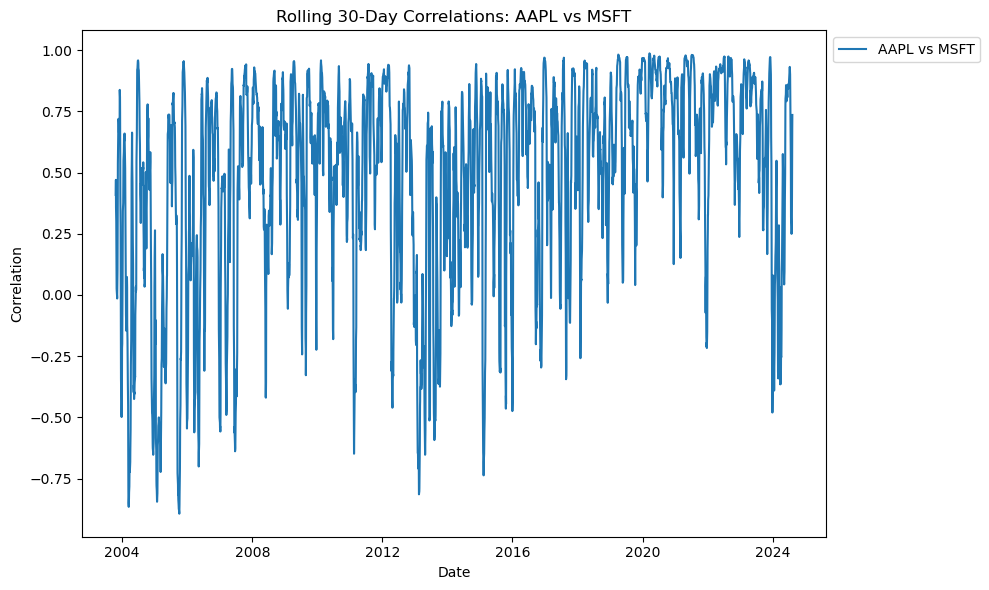

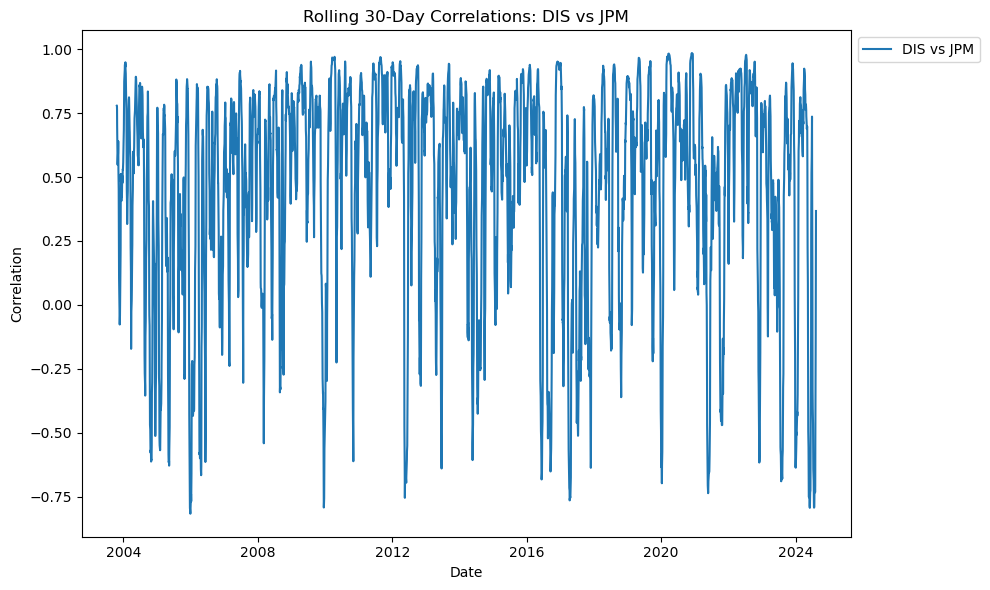

In [9]:
data_viz.rolling_corr(column='close', window=30, pairs=[('AAPL', 'MSFT'), ('DIS', 'JPM')])

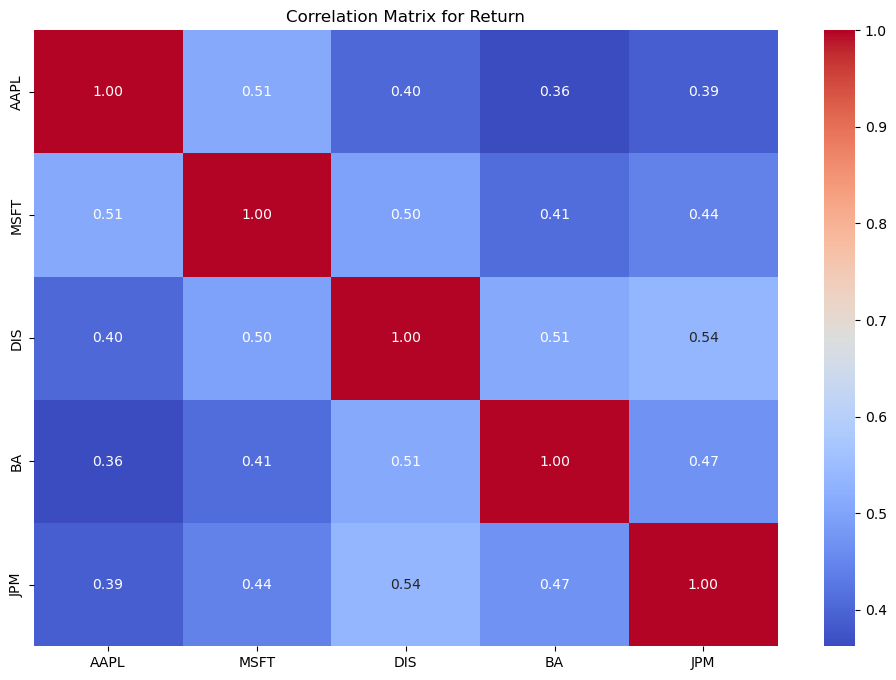

In [10]:
data_viz.correlation_heatmap(column='return')


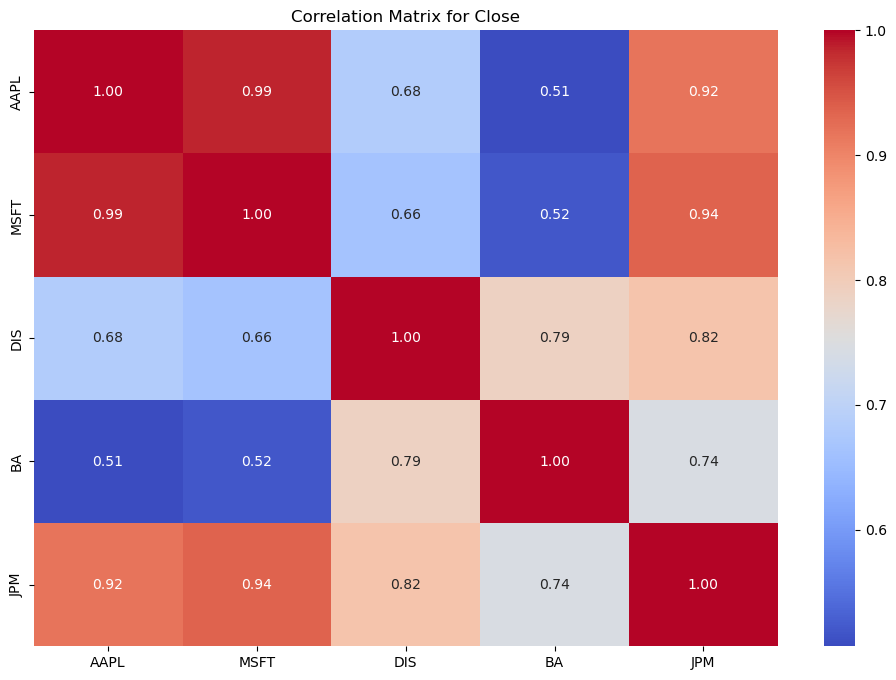

In [11]:
data_viz.correlation_heatmap()

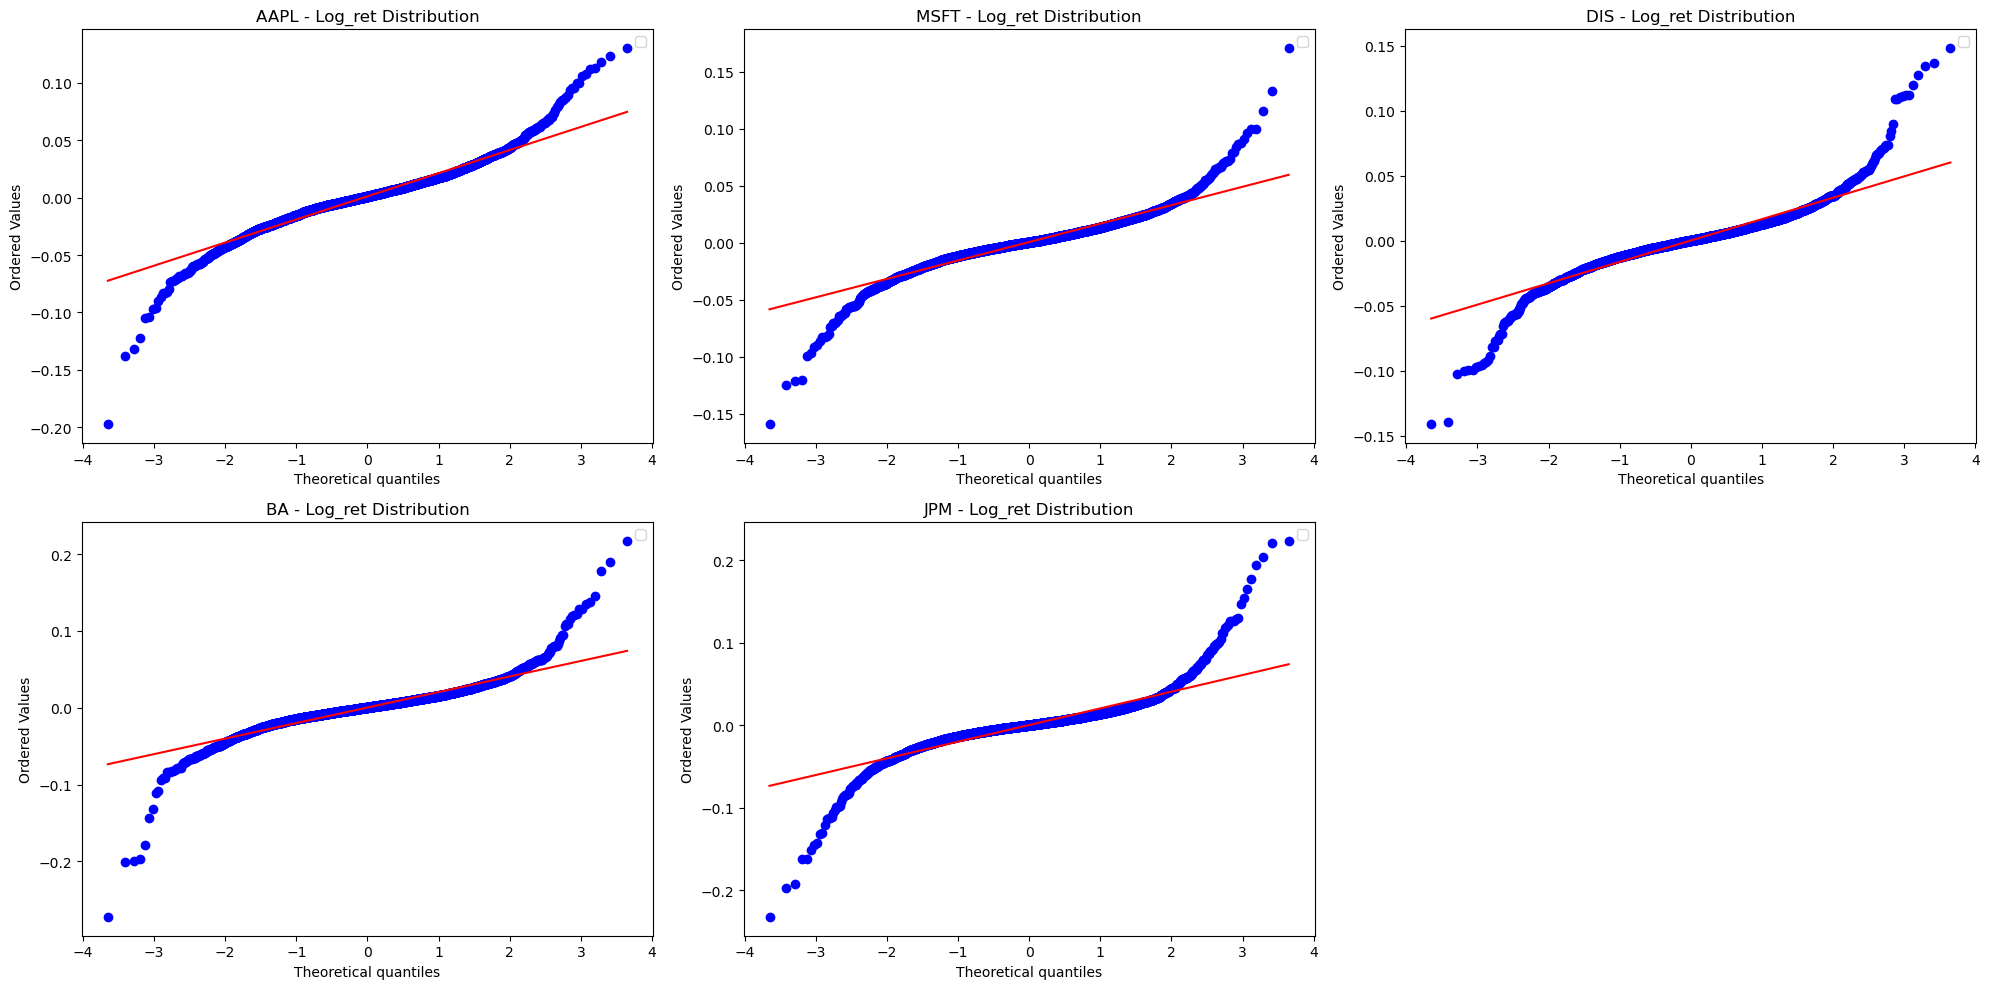

In [12]:
data_viz.plot_distribution()

In [13]:
data_viz.plot_ohlc(tickers = ['AAPL', 'MSFT'])

In [14]:
data_viz.plot_data(column = 'log_ret')